# Reproducibility Project Draft for CS598 DL4H in Spring 2023
# Notebook accompanying project draft submission
## Author: Martin Tomis
## Author email: mtomis2@illinois.edu
## Group ID: 69
## Paper ID: 149


This is a jupyter notebook with my attempt to replicate the model descibed in paper "Explainable Automated Coding of Clinical Notes using Hierarchical Label-wise Attention Networks and Label Embedding Initialisation by Hang et al." The paper introduces a novel solution of a crucial problem - predicting medical codes from Electronic Health Records (EHR).

The combination of attention and of leveraging the hierarchy of medical codes leads the authors to describing the solution as ”Hierarchical Label-wise Attention Networks” (HLAN). The authors also use the initialisation of embeddings which captures the correlation among the labels.

The key components of the HLAN model are:
- Hierarchical: model leverages the structure of a medical code, linking individual words to sentences and sentences to the document.
- Label-wise: essentially each code has its own set of parameters.
- Attention: attention mechanism is state-of-the-art for many NLP tasks.
- Network: these components are connected within a framework of deep-learning model layers.

The rest of this notebook describes steps following the preparation of the immediate input files. Preparation of the raw dataset is described in a separate jupyter notebook in this repo.

In [1]:
import sys

import numpy as np
import pandas as pd

from collections import Counter, defaultdict
import csv
import os
import math
import operator
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import *

from time import *



### Loading inputs
This step assumes that data was pre-processed using the instructions in https://github.com/acadTags/Explainable-Automated-Medical-Coding/tree/master/datasets and most importantly, instructions and code provided in https://github.com/jamesmullenbach/caml-mimic.

Likely due to memory issues, the final model cannot be run on the full dataset.

In [2]:
notes_train = pd.read_csv(os.path.join(os.getcwd(), "Data/mimic-iii/train_50.csv"))
notes_train = notes_train.sample(frac=0.25)

In [3]:
notes_test = pd.read_csv(os.path.join(os.getcwd(), "Data/mimic-iii/test_50.csv"))
notes_test = notes_test.sample(frac=0.25)

In [4]:
embeddings = pd.read_csv(os.path.join(os.getcwd(), "Data/mimic-iii/processed_full.embed"), delimiter=' ', header = None)


In [5]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,**PAD**,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,000cc,0.031379,-0.016026,-0.007015,0.026159,-0.000628,-0.029135,0.037267,0.026875,0.040712,...,-0.027516,0.080226,0.007671,-0.039936,0.010744,-0.006892,-0.071733,0.034608,-0.026505,0.020716
2,000mcg,0.045996,-0.052848,-0.044482,0.045182,0.022560,0.037396,0.026134,0.047924,0.002321,...,-0.020273,0.021479,0.037988,0.075513,0.104129,-0.045498,0.007735,0.000838,0.001557,-0.024968
3,000mg,0.250123,0.174383,-0.269695,0.056581,-0.065816,-0.124786,-0.088935,-0.279940,0.048762,...,0.206152,0.156756,-0.059231,-0.166126,-0.129042,-0.454636,-0.695260,0.101938,0.059170,-0.231901
4,000s,0.061875,-0.044950,-0.132188,0.054579,-0.045981,-0.082330,0.084938,0.005535,0.129054,...,-0.289205,0.187125,-0.239062,-0.010229,-0.063107,0.296233,-0.024894,-0.179583,-0.183988,-0.052326


#### Reformatting embeddings so that it can be used by torch function nn.Embedding.from_pretrained

In [6]:
embeddings.columns = ['WORD'] + [str(i) for i in range(100)]

In [7]:
embeddings.index = embeddings['WORD']
embeddings = embeddings.drop('WORD', axis=1)

In [8]:
weights = torch.tensor(embeddings.values) # formerly syn0,

#### Add multi-hot encoding for labels - ensure consistent encoding for Train / Test
Current implementation fails on some small subsets if there are not all inputs represented.

In [9]:
def create_labels(Y, labels_dict = None, create = False):

    if create:
        labels_dict = {}
        j = 0
        for y in Y:
            labels = str(y).split(";")
            for label in labels:
                if label not in labels_dict:
                    labels_dict[label] = j
                    j+=1
                
    y_tensor = torch.zeros([len(Y), len(labels_dict)])
    
    for _, y in enumerate(Y):
        labels = str(y).split(";")
        for label in labels:
            idx = labels_dict[label]
            y_tensor[_, idx] = 1
    return y_tensor, labels_dict
            

In [10]:
Y_train,labels_dict_ = create_labels(notes_train.LABELS, None, True)
Y_test, labels_dict_check = create_labels(notes_test.LABELS,labels_dict_)

#### Create word-to-index mapping for assigning embeddings

In [11]:
word_to_ids = {}
for i, word in enumerate(embeddings.index):
    word_to_ids[word] = i

#### Max length - helper function to get correct dimension

In [12]:
def get_max_length(X_):
    X = X_.TEXT
    j = 0
    not_found_words = {}
    max_length = 0
    for x in X:
        words = x.split(' ')

        j = 0
        for word in words:
#            if word in word_to_ids:
            j+=1
        if j > max_length:
            max_length = j
    return max_length
    

In [13]:
max_length = max(get_max_length(notes_train),get_max_length(notes_test))

In [14]:
max_length

6120

In [15]:
get_max_length(notes_train)

6120

In [16]:
get_max_length(notes_test)

5630

#### Transform text to index matrix

In [17]:
def length_(row_):
    return len(row_['TEXT'].split(' '))



In [18]:
notes_train['length'] = notes_train.apply(length_, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0636f3250>]],
      dtype=object)

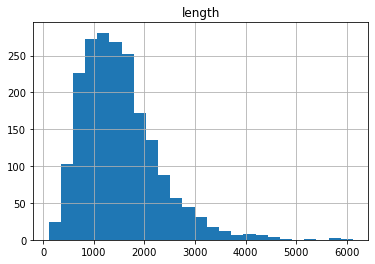

In [19]:
notes_train.hist(column='length',bins=25)

In [20]:
notes_test['length'] = notes_test.apply(length_, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb063802490>]],
      dtype=object)

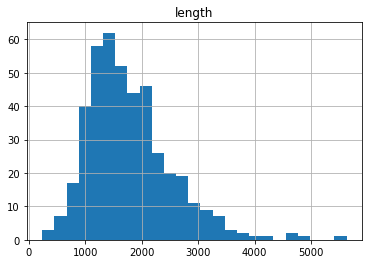

In [21]:
notes_test.hist(column='length',bins=25)

In [22]:
def create_index_tensor(X_, max_length, word_to_ids):
    index_tensor = torch.zeros([X_.shape[0], max_length])
    
    for i, row in enumerate(X_):
        words = row.split(' ')[:max_length]
        for j, word in enumerate(words):
            if word in word_to_ids:
                index_tensor[i,j] = word_to_ids[word]
    return index_tensor
                
    
    

In [23]:
#index_tensor_train = create_index_tensor(notes_train.TEXT, 4000, word_to_ids)
#index_tensor_test =  create_index_tensor(notes_test.TEXT, 4000, word_to_ids)

In [24]:
index_tensor_train = create_index_tensor(notes_train.TEXT, max_length, word_to_ids)
index_tensor_test =  create_index_tensor(notes_test.TEXT, max_length, word_to_ids)

In [25]:
index_tensor_train

tensor([[ 4406., 14227., 15751.,  ...,     0.,     0.,     0.],
        [ 4406., 14227., 15751.,  ...,     0.,     0.,     0.],
        [ 4406., 14227., 15751.,  ...,     0.,     0.,     0.],
        ...,
        [ 4406., 14227., 15751.,  ...,     0.,     0.,     0.],
        [ 4406., 14227., 15751.,  ...,     0.,     0.,     0.],
        [ 4406., 14227., 15751.,  ...,     0.,     0.,     0.]])

#### Similar steps as in HLAN paper - word encoder (first part). Splitting of notes into sentences.

In [26]:
embeds = nn.Embedding.from_pretrained(weights)


In [27]:
def split_embed_reshape(X_indices,embeddings, chunk_size, Y):
    # split
    
    x_tensor = []
    y_tensor = []
    max_l = 0
    
    for _, row in enumerate(X_indices):
        row_chunks = list(torch.split(row, chunk_size))
        if max_l < len(row_chunks):
            max_l = len(row_chunks)
            max_index = _
        all_zero_index = []
        non_zero_counter = 0
        for i, row_chunk in enumerate(row_chunks):
            if torch.all(row_chunk==0.0):
                all_zero_index.append(i)
            else:
                all_zero_index.append(0)
                non_zero_counter += 1
        if len(row_chunk) != chunk_size:
            row_chunks[i] = torch.cat((row_chunk, torch.zeros(chunk_size-len(row_chunk))))
         
        if non_zero_counter == 0:
            print("non_zero_counter is 0")
            y = torch.vstack([Y[_]]* 1)
        else:
            y = torch.vstack([Y[_]]* non_zero_counter)
            
            
        for idx in sorted(all_zero_index, reverse = True):
            if idx != 0:
                del row_chunks[idx]
         
        # embed
        embedding_vectors =[]
        for row_chunk in row_chunks:
            #print(row_chunk.to(torch.long))
            embedding_vectors.append(embeddings(row_chunk.to(torch.long)))
        x_embeddings = torch.vstack(embedding_vectors)
        x_embeddings = torch.reshape(x_embeddings, (len(row_chunks) ,chunk_size,  100))
        x_tensor.append(x_embeddings)
        
        y_tensor.append(y)
        
    return torch.vstack(x_tensor).to(torch.double),torch.vstack(y_tensor).to(torch.double), max_l, max_index
        
    

#### Create test and train data

In [28]:
X_train, Y_train, ml, mi = split_embed_reshape(index_tensor_train, embeds, 50, Y_train )

In [29]:
X_test, Y_test, ml, mi  = split_embed_reshape(index_tensor_test, embeds, 50, Y_test)

### Mine architecture

Hierarchical structure should be is as follows:¶
1. Word Encoder - Bi-Directional GRU, preceeded by procedding shown above.
2. Word-level Attention - attention - detailed comments are in the attention_word_level_ method below.
3. Sentence Encoder - Bi-Directional GRU, 
4. Sentence-level Attention - detailed comments are in the attention_sentence_level_ method below.
5. Linear classifier.

The original paper shows the architecture as follows:


![image](HLAN-architecture.png "Title")

In [30]:
class HAN(nn.Module):
    
    def __init__(self, chunk_size = 50, embedding_dim=100, num_classes = 50, sentence_dim = 10):
        super().__init__()

        self.rnn_naive = nn.GRU(embedding_dim, embedding_dim, batch_first=True)

        self.gru_word_level = nn.GRU(embedding_dim, embedding_dim, 1, batch_first=True,bidirectional=False)
        self.gru_sentence_level = nn.GRU(sentence_dim, sentence_dim, 1, batch_first=True,bidirectional=False)

    
        self.sigmoid = nn.Sigmoid()
        
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.chunk_size = chunk_size
        self.sentence_dim = sentence_dim
        
        
        
        self.hidden_size = 10
        self.softmax_logit = nn.Softmax(dim=1)
        
        self.context_word_att = nn.Linear(2* self.embedding_dim, 2*self.embedding_dim)
        self.context_sentence_att = nn.Linear(2* self.sentence_dim, 2*self.sentence_dim)
        self.fc = nn.Linear(2*self.sentence_dim, self.num_classes)
        self.fc_naive =  nn.Linear(embedding_dim*2, num_classes)
        
        
    def gru_backward_word_level_(self, x):
        h_t_backward_list = []
        for _, row in enumerate(x):
            embedded_words_splitted = list(torch.split(row, self.chunk_size))
            embedded_words_squeeze = [torch.squeeze(x, axis=1) for x in embedded_words_splitted]
            embedded_words_squeeze.reverse()
            h_t = torch.ones_like(embedded_words_squeeze[0])
            h_t = torch.unsqueeze(h_t, 0)

            
            temp_list = []


            for time_step, Xt in enumerate(embedded_words_squeeze):
                Xt = torch.unsqueeze(Xt, 0)
                Xt = torch.reshape(h_t, (Xt.shape[1], Xt.shape[0],Xt.shape[2] ))
                output, h_t = self.gru_word_level(Xt.float(), h_t.float())
                temp_list.append(torch.squeeze(h_t, 0))
            temp_list.reverse()
            h_t_backward_list.extend(temp_list)
        return h_t_backward_list
    
    def gru_forward_word_level_(self, x):
        h_t_forward_list = []
        for _, row in enumerate(x):
            embedded_words_splitted = list(torch.split(row, self.chunk_size))
            embedded_words_squeeze = [torch.squeeze(x, axis=1) for x in embedded_words_splitted]
            
            h_t = torch.ones_like(embedded_words_squeeze[0])
            h_t = torch.unsqueeze(h_t, 0)
            
            temp_list = []

            for time_step, Xt in enumerate(embedded_words_squeeze):
                Xt = torch.unsqueeze(Xt, 0)
                Xt = torch.reshape(h_t, (Xt.shape[1], Xt.shape[0],Xt.shape[2] ))
                output, h_t = self.gru_word_level(Xt.float(), h_t.float())
                temp_list.append(torch.squeeze(h_t, 0))
            temp_list.reverse()
            h_t_forward_list.extend(temp_list)    
        return h_t_forward_list

    def gru_forward_sentence_level_(self, x):
        h_t_forward_list = []
        for _, row in enumerate(x):
            sentence_representation_splitted  = list(torch.split(row, 200))
            sentence_representation_squeeze = sentence_representation_splitted#[torch.squeeze(x, axis=1) for x in sentence_representation_splitted ]
            h_t = torch.ones_like(sentence_representation_squeeze[0])
            h_t = torch.unsqueeze(h_t, 0)
            h_t = torch.ones([1, 200, self.sentence_dim])
            temp_list = []

            for time_step, Xt in enumerate(sentence_representation_squeeze):

                Xt = torch.unsqueeze(Xt, 1)
                Xt = torch.unsqueeze(Xt, 2)
                
                Xt_extended = Xt.repeat(1, 1, self.sentence_dim)
                Xt = Xt_extended
                    
                output, h_t = self.gru_sentence_level(Xt.float(), h_t.float())
                temp_list.append(torch.squeeze(h_t, 0))
            #temp_list.reverse()
            h_t_forward_list.extend(temp_list)    
        return h_t_forward_list
        
    def gru_backward_sentence_level_(self, x):
        h_t_forward_list = []
        for _, row in enumerate(x):
            sentence_representation_splitted  = list(torch.split(row, 200))
            sentence_representation_squeeze = sentence_representation_splitted#[torch.squeeze(x, axis=1) for x in sentence_representation_splitted ]
            
            h_t = torch.ones_like(sentence_representation_squeeze[0])
            h_t = torch.unsqueeze(h_t, 0)
            h_t = torch.ones([1, 200, self.sentence_dim])
            temp_list = []

            for time_step, Xt in enumerate(sentence_representation_squeeze):
                Xt = torch.unsqueeze(Xt, 1)
                Xt = torch.unsqueeze(Xt, 2)
                
                Xt_extended = Xt.repeat(1, 1, self.sentence_dim)
                
                Xt = Xt_extended
 
                output, h_t = self.gru_sentence_level(Xt.float(), h_t.float())
                temp_list.append(torch.squeeze(h_t, 0))
            temp_list.reverse()
            h_t_forward_list.extend(temp_list)    
        return h_t_forward_list
            
        
    def attention_word_level_(self, hidden_state):
        hidden_state_ = torch.stack(hidden_state, axis=0)
        # Attention:
        # 1. Multiply each element of a sentence by matrix (using feed-forward network)
        # 2. Pass through tanh (in paper)
        # 3. Calculate similarity of the input (hidden state) and output of tanh (transformed context)
        # 4. Sum by last dimension (will remain batch x lengt of sentence) and get max by penultimate dimension (label) 
        # 1.
        new_context = self.context_word_att(hidden_state_)
        # 2.
        tan_output_word = torch.tanh(new_context)
        # 3. 
        hidden_state_context_similiarity = hidden_state_.mul(tan_output_word)
        
        # 4. 
        attention_logits = torch.sum(hidden_state_context_similiarity, axis=2) 
        attention_logits_max = torch.max(attention_logits, dim=1, keepdim=True)
        attention_logits_max = attention_logits_max.values.repeat(1,attention_logits.shape[1])

        p_attention = self.softmax_logit(attention_logits - attention_logits_max)

        p_attention_expanded = torch.unsqueeze(p_attention, axis=2)

        sentence_representation = torch.mul(p_attention_expanded, hidden_state_)

        sentence_representation = torch.sum(sentence_representation, axis=1)                                     
        return sentence_representation  

    def attention_sentence_level_(self, hidden_state):
        hidden_state_ = torch.stack(hidden_state, axis=0)
        # Attention:
        # 1. Multiply each element of a sentence by matrix (using feed-forward network)
        # 2. Pass through tanh (in paper)
        # 3. Calculate similarity of the input (hidden state) and output of tanh (transformed context)
        # 4. Sum by last dimension (will remain batch x lengt of sentence) and get max by penultimate dimension (label) 
        # 1.
        new_context = self.context_sentence_att(hidden_state_)
        # 2.
        tan_output_word = torch.tanh(new_context)
        # 3. 
        hidden_state_context_similiarity = hidden_state_.mul(tan_output_word)
        
        # 4. 
        attention_logits = torch.sum(hidden_state_context_similiarity, axis=2) 
        attention_logits_max = torch.max(attention_logits, dim=1, keepdim=True)
        attention_logits_max = attention_logits_max.values.repeat(1,attention_logits.shape[1])

        p_attention = self.softmax_logit(attention_logits - attention_logits_max)

        p_attention_expanded = torch.unsqueeze(p_attention, axis=2)

        sentence_representation = torch.mul(p_attention_expanded, hidden_state_)

        sentence_representation = torch.sum(sentence_representation, axis=1)                                     
        return sentence_representation 


    
    def forward(self, x):
        # 1. Rest of Word Encoder
        hidden_state_back = self.gru_backward_word_level_(x)
        hidden_state_for = self.gru_forward_word_level_(x)

        hidden_state_combined_gru = [torch.cat([h_forward, h_backward], axis=1) for h_forward, h_backward in
                             zip(hidden_state_for, hidden_state_back)]
        

        
        # 2.Word Attention
        # for each sentence.

        sentence_representation = self.attention_word_level_(hidden_state_combined_gru)
        
        # 3. Sentence-level GRU
        hidden_state_forward_sentences = self.gru_forward_sentence_level_(sentence_representation)
        hidden_state_backward_sentences = self.gru_backward_sentence_level_(sentence_representation)

        
        hidden_state_combined_gru = [torch.cat([h_forward, h_backward], axis=1) for h_forward, h_backward in
                             zip(hidden_state_forward_sentences, hidden_state_backward_sentences)]
        
        # 4. Sentence-level attention
        document_representation = self.attention_sentence_level_(hidden_state_combined_gru) 
        
        # 5. Linear Classifier

        logits = self.fc(document_representation)
        
        probs = self.sigmoid(logits)
        
        
        
        return probs.squeeze(dim=-1)
    

In [31]:
model = HAN()

In [32]:
model.eval()



HAN(
  (rnn_naive): GRU(100, 100, batch_first=True)
  (gru_word_level): GRU(100, 100, batch_first=True)
  (gru_sentence_level): GRU(10, 10, batch_first=True)
  (sigmoid): Sigmoid()
  (softmax_logit): Softmax(dim=1)
  (context_word_att): Linear(in_features=200, out_features=200, bias=True)
  (context_sentence_att): Linear(in_features=20, out_features=20, bias=True)
  (fc): Linear(in_features=20, out_features=50, bias=True)
  (fc_naive): Linear(in_features=200, out_features=50, bias=True)
)

### training

In [33]:
BATCH_SIZE = 32
EPOCHS = 10





learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

batch_losses = []
criterion = nn.BCELoss()

for epoch in range(EPOCHS):
    print("Epoch number: {}".format(epoch))
    t0 = time()
    for i in range(0, len(X_train), BATCH_SIZE):
        x, y = X_train[i:i+BATCH_SIZE], Y_train[i:i+BATCH_SIZE]
        #print("y")
        #print(y.shape) 32 x 50
        optimizer.zero_grad()
        y_hat = model(x.float())
        loss = criterion(y_hat, y.type(torch.float))
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)
    t1 = time()
    print(f"This epoch took {(t1 - t0) // 60} minutes and {(t1 - t0) % 60} seconds.")
    '''y_hat = model(X_train.float())
    pred = np.array(y_hat > 0.5, dtype=float)
    auc= roc_auc_score(Y_train, y_hat.detach().numpy(), average='macro')
    print("Training data AUC is {}".format(auc))'''

Epoch number: 0
This epoch took 2.0 minutes and 37.268986225128174 seconds.
Epoch number: 1
This epoch took 2.0 minutes and 46.422897815704346 seconds.
Epoch number: 2
This epoch took 2.0 minutes and 37.632731199264526 seconds.
Epoch number: 3
This epoch took 2.0 minutes and 40.94078183174133 seconds.
Epoch number: 4
This epoch took 2.0 minutes and 39.99514079093933 seconds.
Epoch number: 5
This epoch took 2.0 minutes and 37.830681800842285 seconds.
Epoch number: 6
This epoch took 2.0 minutes and 38.94284272193909 seconds.
Epoch number: 7
This epoch took 2.0 minutes and 38.49711799621582 seconds.
Epoch number: 8
This epoch took 2.0 minutes and 38.148216009140015 seconds.
Epoch number: 9
This epoch took 2.0 minutes and 38.240350008010864 seconds.


#### Test data

In [34]:
y_hat = model(X_test.float())
pred = np.array(y_hat > 0.5, dtype=float)
auc= roc_auc_score(Y_test, y_hat.detach().numpy(), average='macro')
print("Testing data AUC is {}".format(auc))

Testing data AUC is 0.49999719809470444


#### Train data

In [35]:
y_hat = model(X_train.float())
pred = np.array(y_hat > 0.5, dtype=float)
auc= roc_auc_score(Y_train, y_hat.detach().numpy(), average='macro')
print("Training data AUC is {}".format(auc))

Training data AUC is 0.5
